### Face Verification
In the first tutorial, we saw how the pre-trained VGG-Face network can be used to recognize faces of certain celebrity identities. In facial analysis literature, this is referred to as the "face identification" problem. That is, given a face image, face identification can be used to map the input image to a single identity from a pre-defined list of identities. There is another, related problem in this space which is called "face verification". Given two face images, the aim of verification is to tell us whether they belong to the same identity or not. On the basis of the definitions, it is easy to see that identification is a multi-class problem whereas verification is a binary classification problem.

In this tutorial, we will see how we can use the pre-trained VGG-Face descriptors for the task of face verification on a challenging dataset called  Celebrities in Frontal-Profile in the Wild (CFPW) [1] 

In [5]:
import cv2, math
import numpy as np

import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models
import os
from sklearn import metrics
from scipy.optimize import brentq
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 
plt.ion()

In [8]:
root = 'data'
eroot = os.path.join(root, 'Experiment_3')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


You might already be familiar with the following function definitions by now -- `loadImage()` which is used to pre-process the input image for the VGG-Face network and `getVggFeatures()` which returns the fc-layer features from the pre-trained VGG-Face network.

In [59]:
def loadImage(imgPath):
    inputImg = cv2.imread(imgPath)

    # re-scale the smaller dim (among width, height) to refSize
    refSize, targetSize = 256, 224
    imgRows, imgCols = inputImg.shape[0], inputImg.shape[1]
    if imgCols < imgRows: resizedImg = cv2.resize(inputImg, (refSize, int(refSize * imgRows / imgCols)))
    else: resizedImg = cv2.resize(inputImg, (int(refSize * imgCols / imgRows), refSize))

    # center-crop
    oH, oW = targetSize, targetSize
    iH, iW = resizedImg.shape[0], resizedImg.shape[1]
    anchorH, anchorW = int(math.ceil((iH - oH)/2)), int(math.ceil((iW - oW) / 2))
    croppedImg = resizedImg[anchorH:anchorH+oH, anchorW:anchorW+oW]

    # convert shape from (height, width, 3) to (3, width, height)
    channel_1, channel_2, channel_3 = croppedImg[:, :, 0], croppedImg[:, :, 1], croppedImg[:, :, 2]
    croppedImg = np.empty([3, croppedImg.shape[0], croppedImg.shape[1]])
    croppedImg[0], croppedImg[1], croppedImg[2] = channel_1, channel_2, channel_3

    # subtract training mean
    inputImg = inputImg.astype(float)
    trainingMean = [129.1863, 104.7624, 93.5940]
    for i in range(3): croppedImg[i] = croppedImg[i] - trainingMean[i]
    return croppedImg


In [61]:
def loadVGGModel( filename):
	dat2 = torch.load(filename)
	# copy dictionary
	if str.split(list(dat2.keys())[0],'.')[0] == 'module':
		dat = {}
		for key in dat2.keys():
			k = '.'.join(str.split(key,'.')[1:])
			dat[k] = dat2[key]
	else:
		dat = dat2
		
	n_classes = dat['classifier.6.bias'].shape[0]
	model = torchvision.models.vgg16(pretrained = False)
	lastlayer = torch.nn.Linear(in_features = model.classifier[-1].in_features, \
							   out_features = n_classes, \
							   bias = True)
	model.classifier[-1] = lastlayer
	model.load_state_dict(dat)
	return model

def getFeature(x, model):
	# replicate the forward function
	x = model.features(x)
	x = model.avgpool(x)
	x = torch.flatten(x, 1)
	# forward pass only through the first 4 layers of the classifier
	for ii in range(4):
		x = model.classifier[ii](x)
	return x

def getVggFeatures(imgPaths, preTrainedNet):
    nImgs = len(imgPaths)
    
    batchInput = torch.Tensor(nImgs, 3, 224, 224)
    for i in range(nImgs): batchInput[i] = torch.from_numpy(loadImage(imgPaths[i]))
    
    batchOutput = getFeature(batchInput.to(device), preTrainedNet)
    return batchOutput.detach().cpu()

Let us load the dataset and try to visualize the images in the dataset. Since we will be doing verification, the dataset is given in the form of image pairs.

In [27]:
class record():
	def __init__(self, dat):
		self.img1 = str(dat[b'img1'], 'UTF8')
		self.img2 = str(dat[b'img2'], 'UTF8')
		self.label = dat[b'label']
		
	def __str__(self):
		return f'img1: {self.img1}, img2: {self.img2}, label: {self.label}'

In [42]:
dataset = np.load(eroot + '/cfpw-pairs-dataset.npy', allow_pickle=True)
print("# image pairs in the dataset = ", len(dataset))

# image pairs in the dataset =  100


There are 100 image pairs in the dataset. Each image pair is asociated with a label of either "+1" or "-1" denoting whether the two images in the pair belong to the same or different individuals respectively.

Let us see an example of an image pair where both faces belong to the same identity.

label =  1


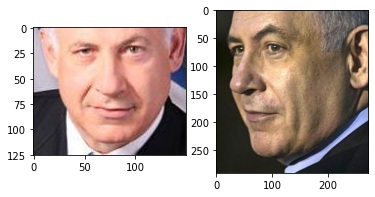

In [46]:
imgPath1 = os.path.join(eroot, dataset[1].img1)
imgPath2 = os.path.join(eroot, dataset[1].img2)
dispImg1, dispImg2 = mpimg.imread(imgPath1), mpimg.imread(imgPath2)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(dispImg1)
axarr[1].imshow(dispImg2)

print("label = ", dataset[1].label)

Let us also look at some examples of image pairs where the faces belong to different identities.

label =  -1


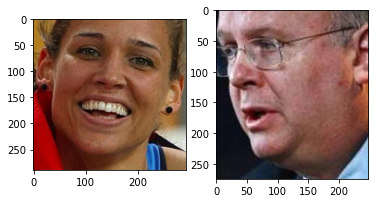

In [49]:
imgPath1 = os.path.join(eroot, dataset[99].img1)
imgPath2 = os.path.join(eroot, dataset[99].img2)
dispImg1, dispImg2 = mpimg.imread(imgPath1), mpimg.imread(imgPath2)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(dispImg1)
axarr[1].imshow(dispImg2)

print("label = ", dataset[99].label)

One aspect among all face pairs in the CFPW dataset is the fact that one of the faces is frontal (looking straight) whereas the other is profile (looking sideways). The presence of such extreme pose variations (frontal-profile) is what makes CFPW a challenging dataset for the task of face verification.

Having looked at our dataset, let us define how we are going to compute the (dis)similarity between two faces in a given pair and then subsequently look at some metrics to judge how we are performing on the verification task.

Since we will be using the pre-trained VGG-Face descriptors as representations for our faces, we load the pre-trained network.

In [50]:
vggFace = loadVGGModel(os.path.join(root, 'VGGFace16.pth'))
vggFace = vggFace.to(device)


Using the above pre-trained network, we will be able to generate the 4096-d representation for each face in the image pair. But, our target task is to determine whether these two faces are the same or not. How do we do that?

The intuitive way to do that would be to compute the L2 distance (or any other distance metric of your choice) between the representations of the two faces, and if this distance is less than a certain threshold value, then we can say that the faces belong to the same identity, otherwise not.

How do define this threshold? We will come to that later. First, let us set up the code to compute the pair-wise L2 distance between all image pairs in our dataset. As always, we will be iterating through our dataset in units of mini-batches while maintaining a global list of L2 distances between all image pairs.

In [62]:
nPairs, batchSize = len(dataset), 10
classifierScores, labels = [], []

for startIdx in range(0, nPairs, batchSize):
    endIdx = min(startIdx+batchSize-1, nPairs-1)
    size = (endIdx - startIdx + 1)

    imgPaths1, imgPaths2, batchLabels = [], [], []
    for offset in range(size):
        pair = dataset[startIdx+offset]
        imgPaths1.append(os.path.join(eroot,  pair.img1))
        imgPaths2.append(os.path.join(eroot,  pair.img2))
        batchLabels.append(int(pair.label) * -1)
    
    descrs1 = getVggFeatures(imgPaths1, vggFace).clone()
    descrs2 = getVggFeatures(imgPaths2, vggFace).clone()
    for i in range(size):
        descr1, descr2 = descrs1[i].numpy(), descrs2[i].numpy()
        normDescr1, normDescr2 = descr1 / np.linalg.norm(descr1), descr2 / np.linalg.norm(descr2)
        classifierScores.append( np.linalg.norm(normDescr1 - normDescr2) )
        labels.append(batchLabels[i])



Now that we have the L2 distances and the corresponding labels, let us return to the question of how to chose a threshold and make predictions for face verification. First, let us understand the role played by a threshold. Given a particular threshold for our verification problem, we can classify each image pair whose distance is less than the threshold as "similar", and likewise for dissimilar. And having done that, we can compute various metrics such as "true positive rate" (tpr) which is the fraction of dissimilar pairs in the dataset which have been correctly classified as being dissimilar. Or, "false positive rate" (fpr) which is the fraction of all similar face pairs which have been wrongly classified as dissimilar. All these metrics are dependent on the threshold that we select.

However, instead of reporting metrics using a single threshold value, we generally chose several possible different thresholds, compute tpr and fpr for all the different values of threshold and plot them in the form of a graph. This is known as the ROC curve (Region Operating Characteristic curve).

After plotting the ROC curve for a binary classifier (such as the one used for face verification), we can select the appropriate threshold value that we wish to "operate" in depending upon the level and the kind of errors that we are willing to tolerate.

We plot the ROC curve for our verification problem below. Also note that another important metric is the area under the ROC curve (AUC -- Area Under Curve). For a good classifier, the AUC value must be as high as possible (maximum value = 1.0).

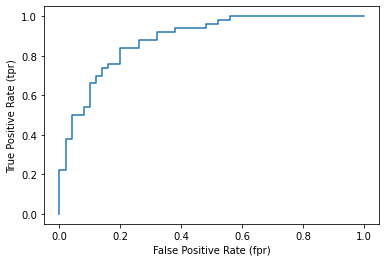

AUC =  0.8852


In [64]:
fpr, tpr, thresholds = metrics.roc_curve(labels, classifierScores)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (fpr)")
plt.ylabel("True Positive Rate (tpr)")
plt.show()

print("AUC = ", auc)

### Exercices
1. Check and compare the face verification accuracies of CFPW dataset with the LFW dataset. Draw both ROC curves in the same plot. For loading the LFW dataset, use the following .t7 file name: lfw-facePairs-dataset.t7 (the rest of the file path remains the same i.e. lfw-facePairs-dataset)

2. Use classifier scores and labels to compute the average L2 distance between similar and dissimilar face pairs.

3. In the code snippet for computing the L2 distance between the image pairs, why are the labels being flipped? (Notice that we are multiplying each label with -1 before adding it to the list of all labels).